<a href="https://colab.research.google.com/github/omh9339/My-Projects/blob/master/SEES_ML_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as pyplot
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 

Using TensorFlow backend.


In [ ]:
#This code is heavily adapted from Jason Brownlee's lstm model code

In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/AirQualityUCI_fixed.csv", index_col = 0)
#dataset.drop(columns ="Time")
values = dataset.values

for row in values:
  date_str = row[0]
  (h, m, s) = date_str.split(':')
  result = int(h) + int(m) * (1/60) + int(s) * (1/3600)
  row[0] = result

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

n_hours = 168
n_hours_to_pred = 24
n_features = 14


# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_hours_to_pred)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[14,15]], axis=1, inplace=True)
print(reframed.head())

     var1(t-168)  var2(t-168)  ...  var13(t+23)  var14(t+23)
168     0.782609     0.956111  ...     0.775546     0.992841
169     0.826087     0.953280  ...     0.785591     0.992650
170     0.869565     0.954224  ...     0.800485     0.992688
171     0.913043     0.954224  ...     0.818150     0.992764
172     0.956522     0.951392  ...     0.860409     0.993304

[5 rows x 2688 columns]


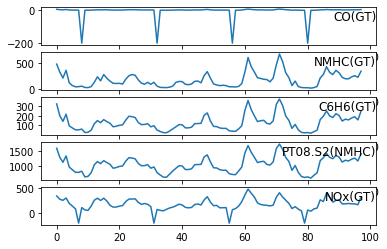

In [ ]:

# specify columns to plot
groups = [ 1, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[50:148][:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
reframed.shape

(9166, 2688)

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 6750
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6750, 1, 2352) (6750, 336) (2416, 1, 2352) (2416, 336)


In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

#train_y = train_y.reshape((train_y.shape[0], n_hours_to_pred, n_features))
#test_y = test_y.reshape((test_y.shape[0], n_hours_to_pred, n_features))

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6750, 168, 14) (6750, 336) (2416, 168, 14) (2416, 336)


Train on 6750 samples, validate on 2416 samples
Epoch 1/100
 - 39s - loss: 0.1591 - val_loss: 0.1156
Epoch 2/100
 - 37s - loss: 0.1167 - val_loss: 0.1119
Epoch 3/100
 - 37s - loss: 0.1102 - val_loss: 0.1032
Epoch 4/100
 - 37s - loss: 0.1007 - val_loss: 0.0970
Epoch 5/100
 - 37s - loss: 0.0959 - val_loss: 0.0917
Epoch 6/100
 - 37s - loss: 0.0931 - val_loss: 0.0872
Epoch 7/100
 - 37s - loss: 0.0887 - val_loss: 0.0854
Epoch 8/100
 - 37s - loss: 0.0857 - val_loss: 0.0815
Epoch 9/100
 - 37s - loss: 0.0833 - val_loss: 0.0799
Epoch 10/100
 - 37s - loss: 0.0811 - val_loss: 0.0779
Epoch 11/100
 - 37s - loss: 0.0794 - val_loss: 0.0758
Epoch 12/100
 - 37s - loss: 0.0780 - val_loss: 0.0746
Epoch 13/100
 - 36s - loss: 0.0771 - val_loss: 0.0745
Epoch 14/100
 - 36s - loss: 0.0763 - val_loss: 0.0733
Epoch 15/100
 - 37s - loss: 0.0753 - val_loss: 0.0729
Epoch 16/100
 - 37s - loss: 0.0745 - val_loss: 0.0723
Epoch 17/100
 - 37s - loss: 0.0741 - val_loss: 0.0719
Epoch 18/100
 - 37s - loss: 0.0735 - val_lo

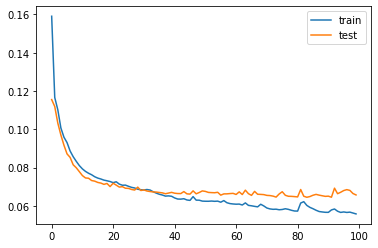

In [ ]:
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(336))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
test_X.shape

(3166, 2352)

(24, 14)

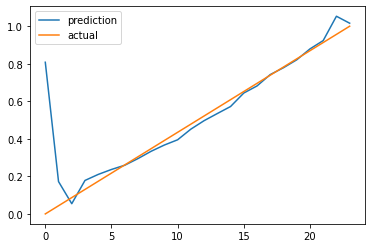

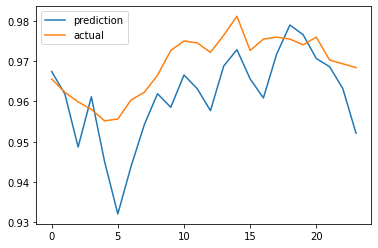

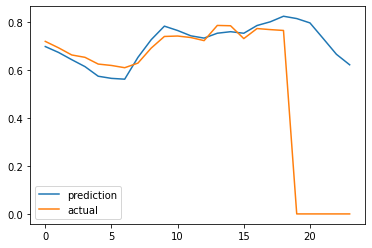

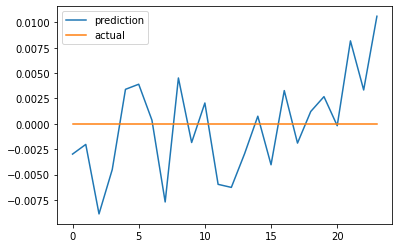

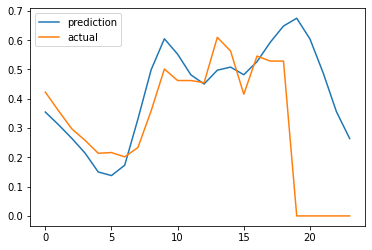

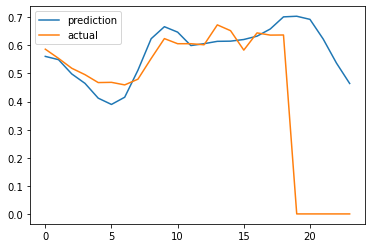

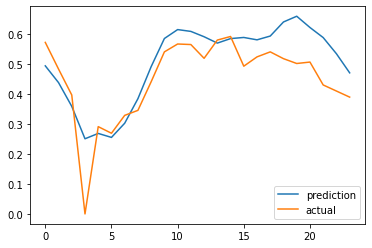

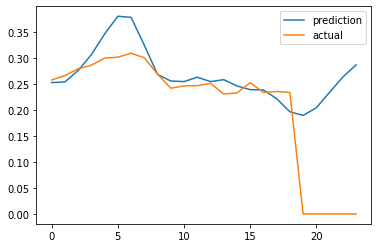

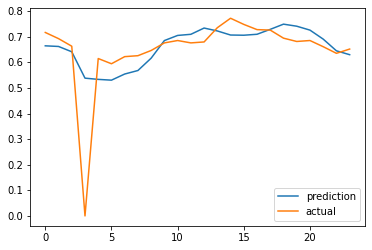

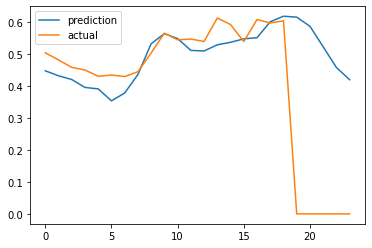

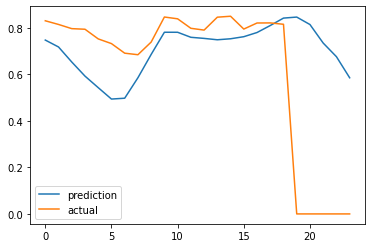

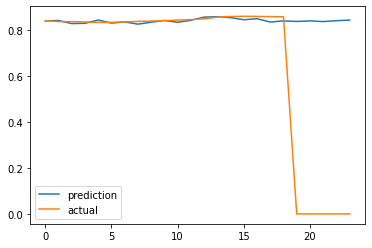

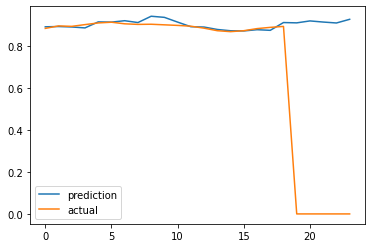

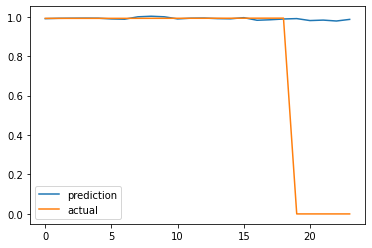

In [ ]:
#plots for V1 50 units, 100 epochs

for i in range(14):
  pyplot.plot(pred[:,i], label='prediction')
  pyplot.plot(actual[:,i], label='actual')

  #pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

In [ ]:
ind = 480
test = test_X[ind]
reshaped_test = np.expand_dims(test, 0)

actual = test_y[ind]
actual = np.reshape(actual, (24,14))

pred = modelv2.predict(reshaped_test)
pred = np.reshape(pred, (24,14))


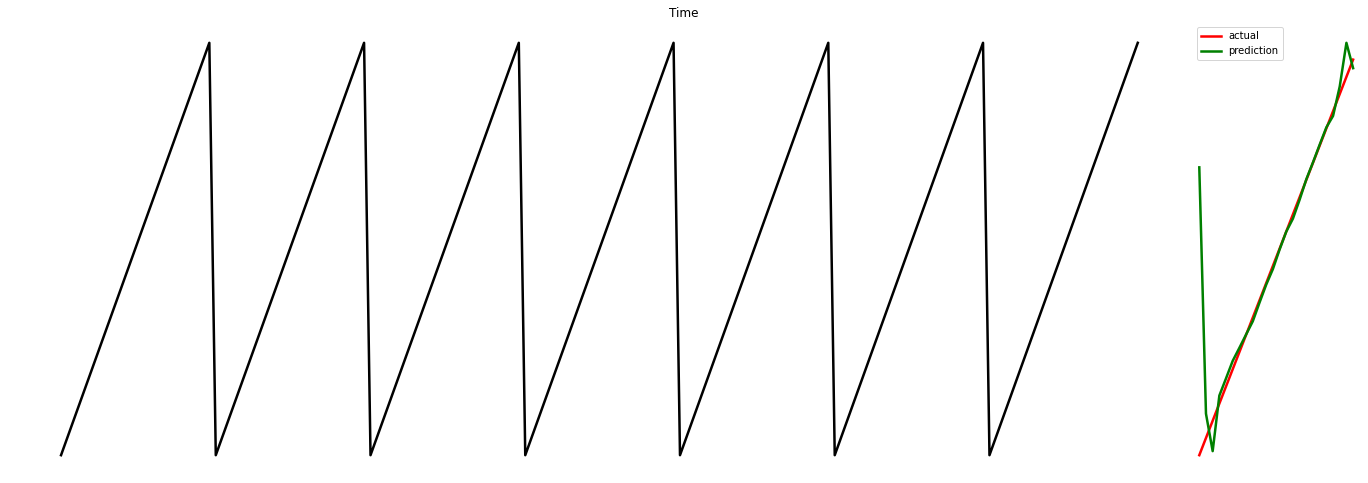

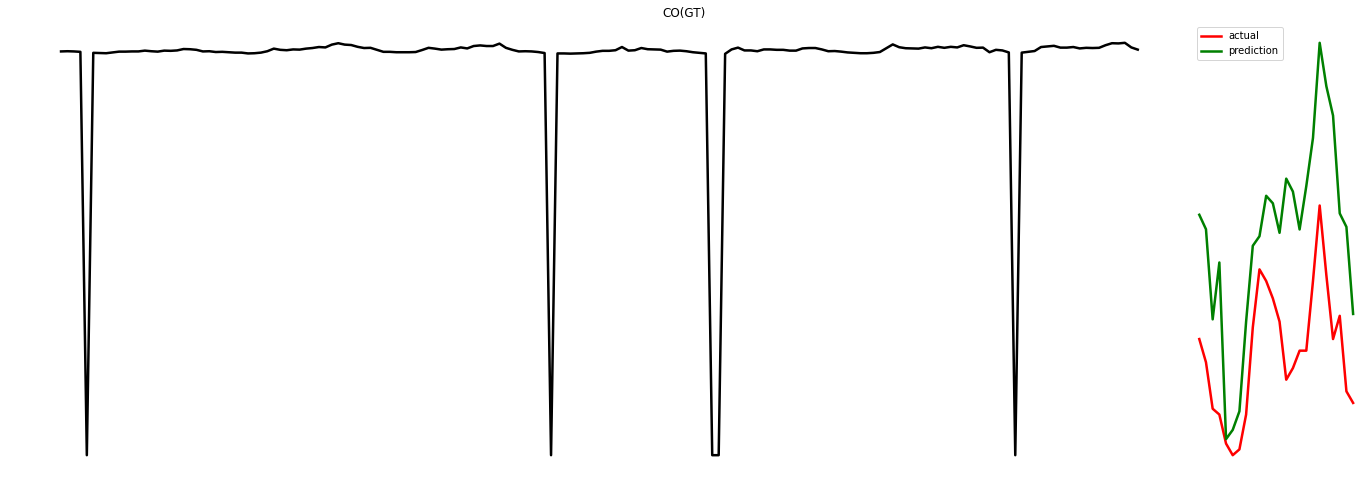

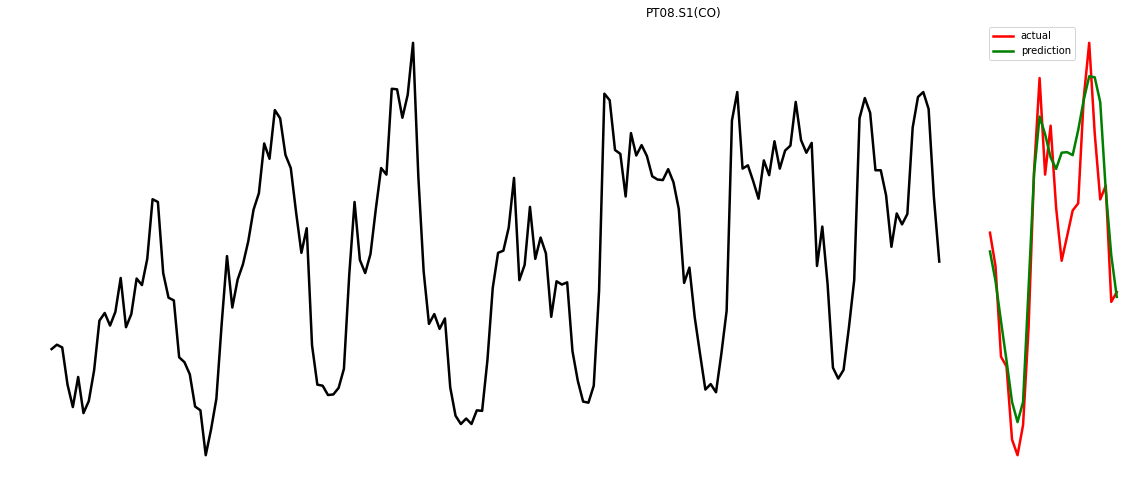

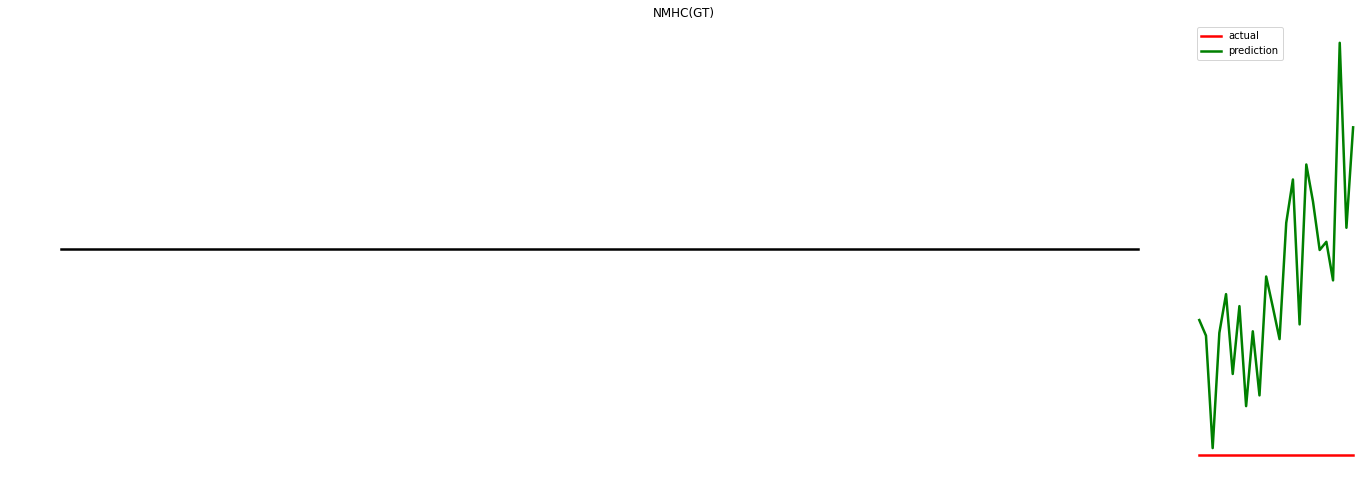

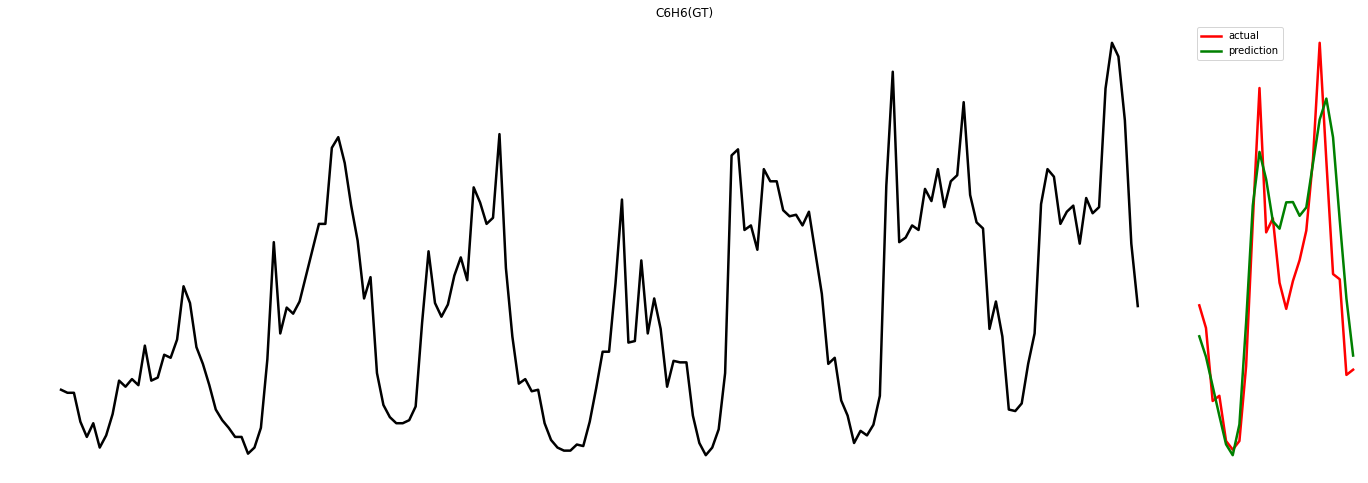

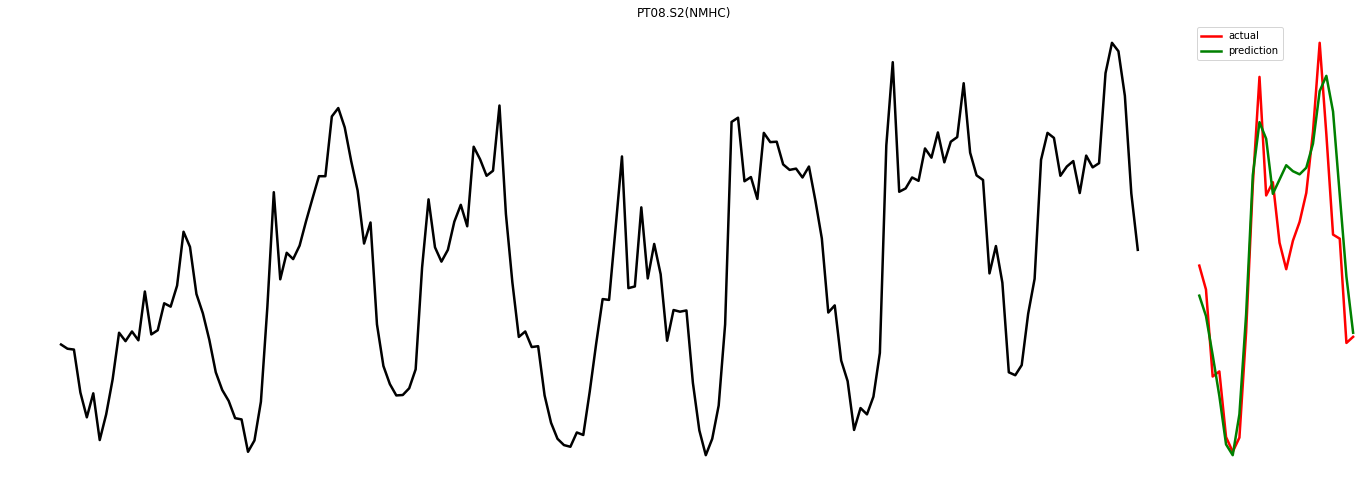

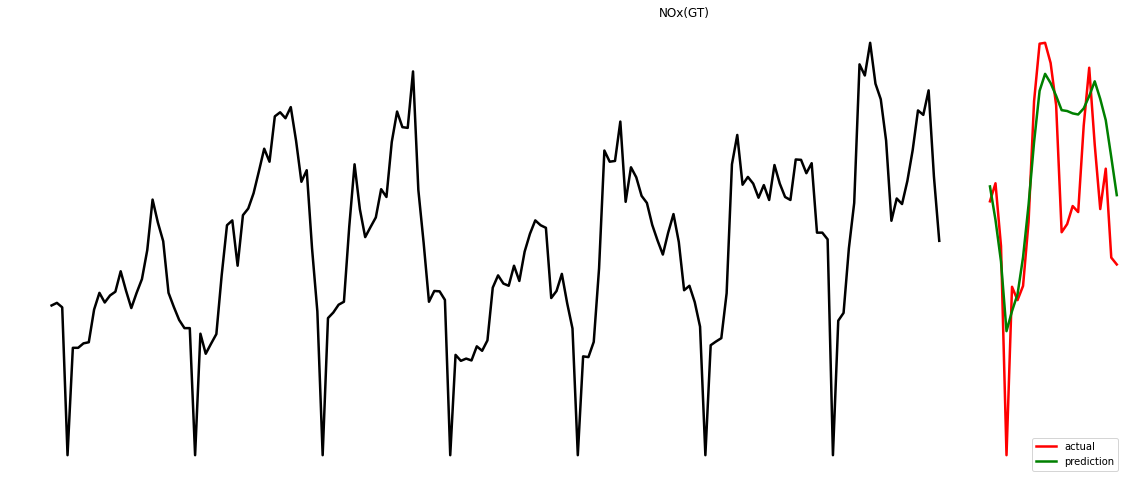

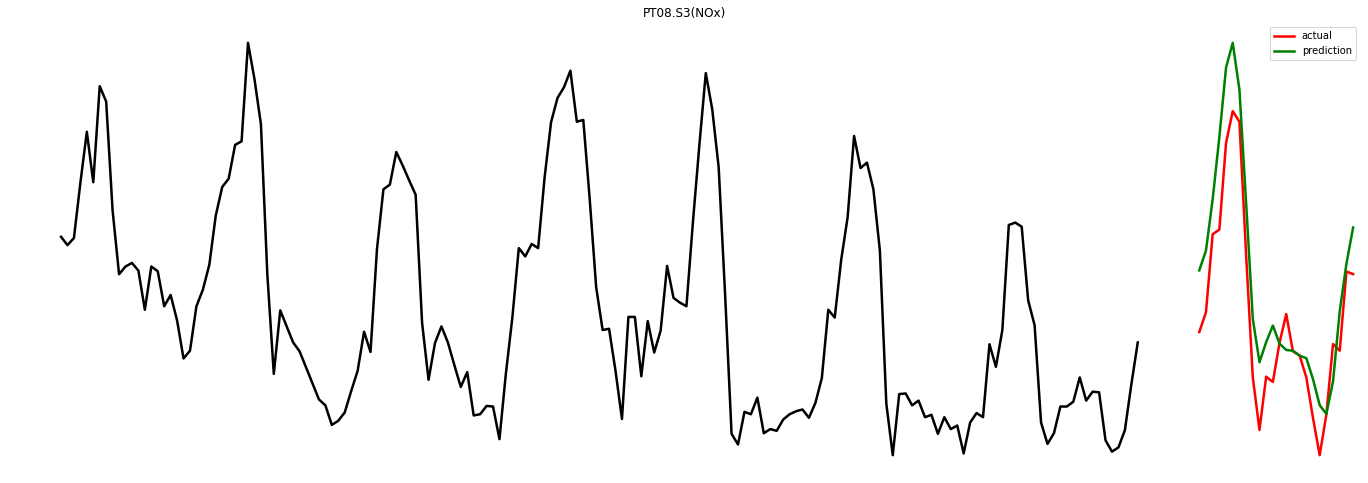

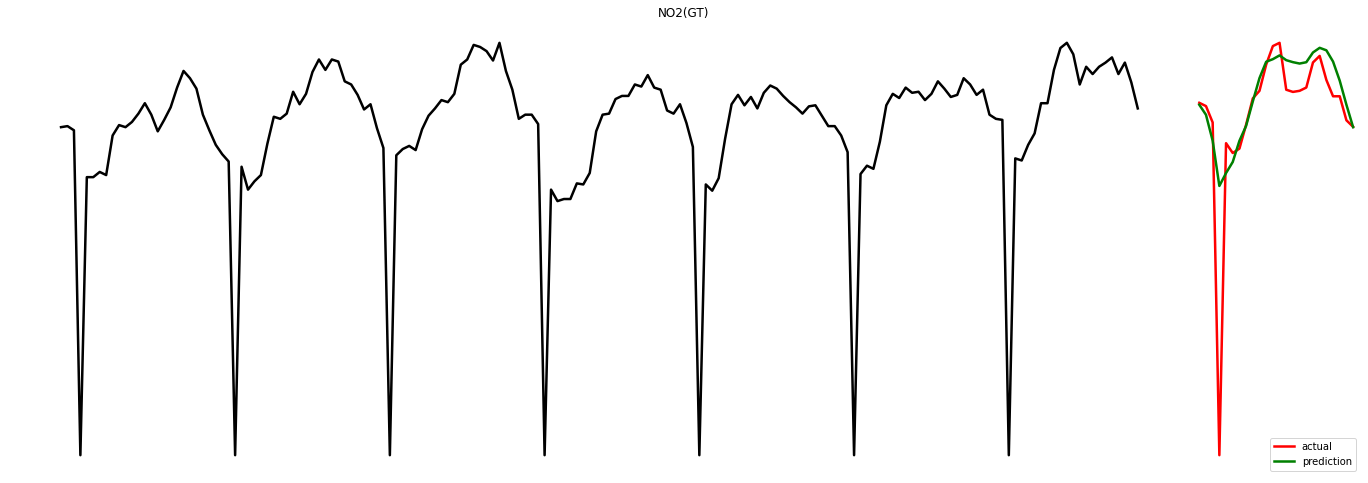

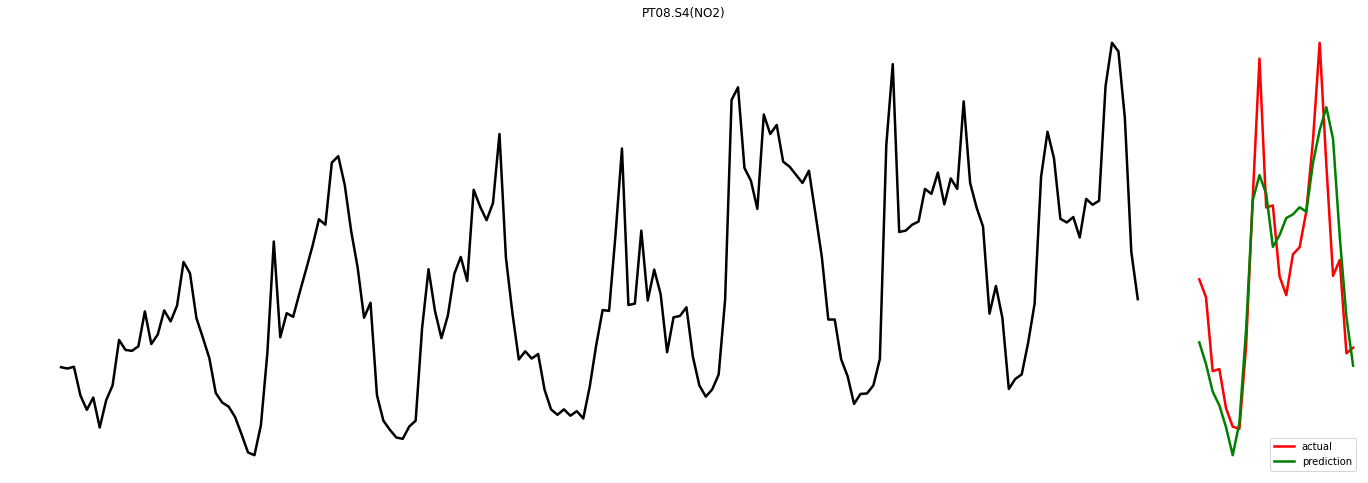

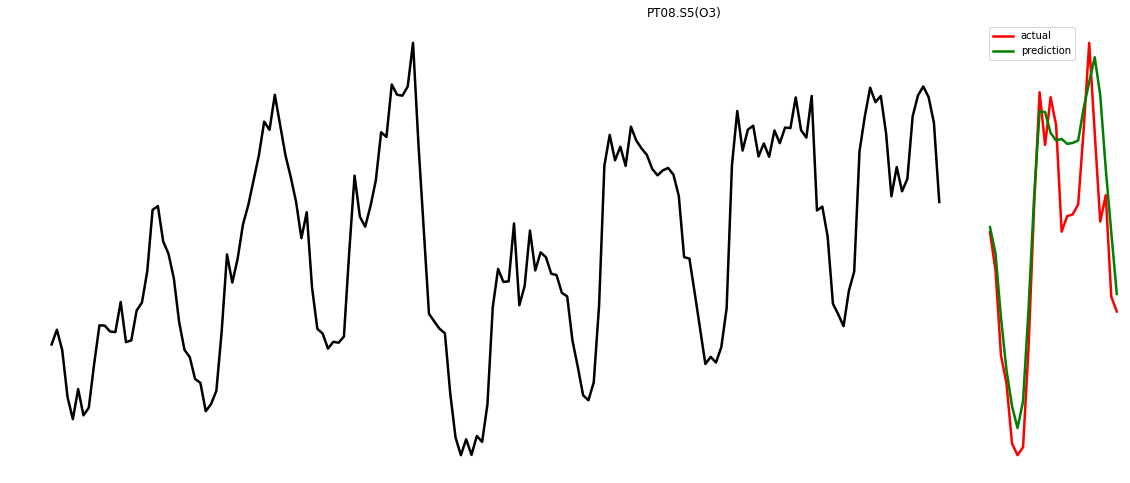

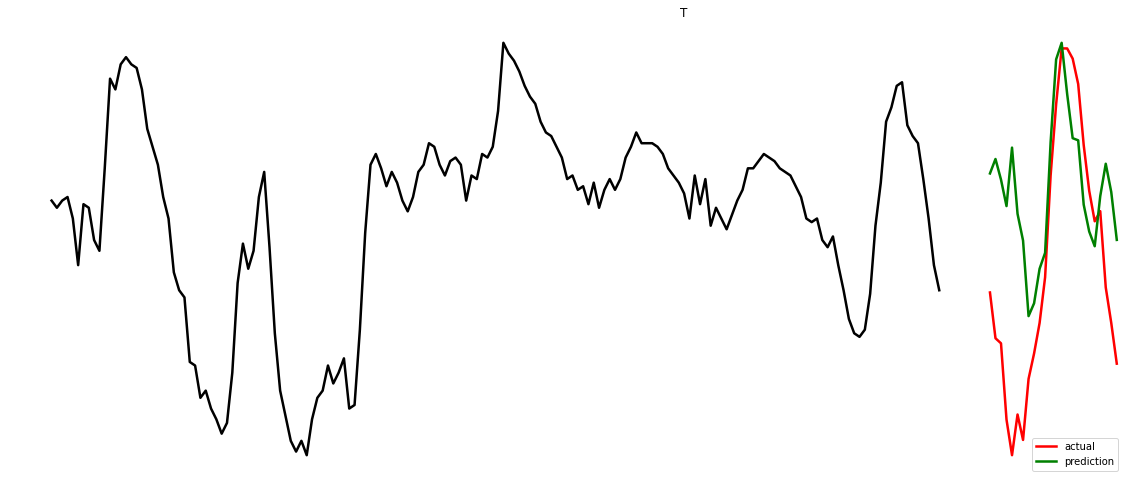

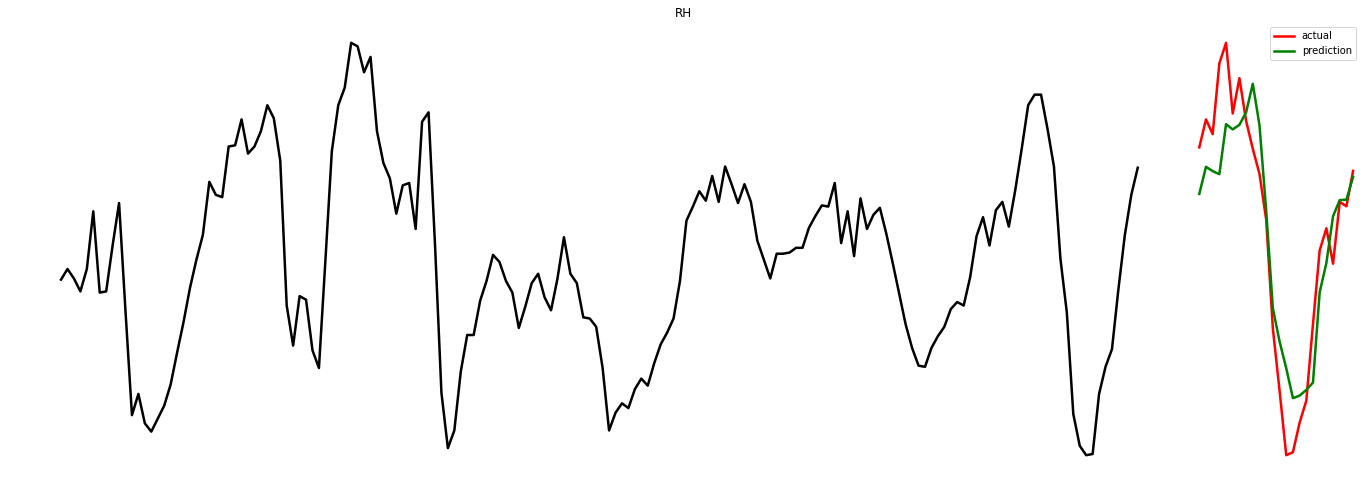

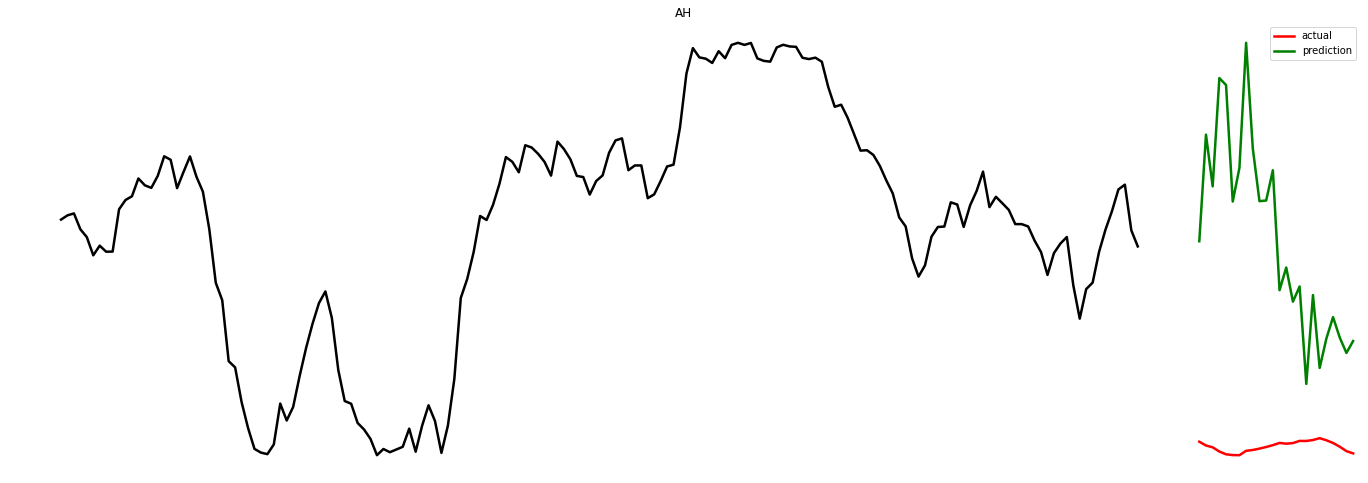

In [ ]:
#plots for V2 150 units, 100 epochs
name_list = list(dataset.columns)

for i in range(14):
  #pyplot.plot(pred[:,i], label='prediction')
  #pyplot.plot(actual[:,i], label='actual')
  #pyplot.plot(test[:,i])

  fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(5, 3), gridspec_kw={'width_ratios': [7, 1]})
  fig.suptitle(name_list[i])
  gs1 = gridspec.GridSpec(2, 1)
  gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

  axes[0].plot(test[:,i], label='Data given to ML algorithm', color = "k",linewidth=2.5)
  axes[0].axis('off')
  
  axes[1].plot(actual[:,i], label='actual', color = "r",linewidth=2.5 )
  axes[1].plot(pred[:,i], label='prediction', color = "g",linewidth=2.5)

  axes[1].axis('off')

  #fig.tight_layout()
  #pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()



  # fit subplots and save fig
  fig.tight_layout()
  fig.set_size_inches(w=20,h=7)
  pyplot.subplots_adjust(wspace=0, hspace=0)
  pyplot.show()


In [ ]:
array = [[1,2], [2, 4], [3, 9], [4,5]]
pyplot.plot(array[:,0], array[:,1])

TypeError: ignored

In [ ]:
model.save('/content/drive/My Drive/SEES/saved_model_v2')


In [ ]:
from tensorflow import keras

modelv2 = keras.models.load_model('/content/drive/My Drive/SEES/saved_model_v2')


In [ ]:
model2

Epoch 1/3
84/84 - 1s - loss: 0.0612 - val_loss: 0.0732
Epoch 2/3
84/84 - 1s - loss: 0.0610 - val_loss: 0.0732
Epoch 3/3
84/84 - 1s - loss: 0.0609 - val_loss: 0.0731


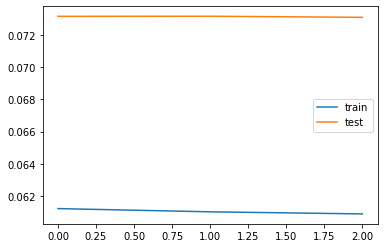

In [ ]:
history = model2.fit(train_X, train_y, epochs=3, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()